In [ ]:
IRdisplay::display_html("
<style>
.rendered_html table, .rendered_html th, .rendered_html tr, .rendered_html td {
     font-size: 100%;
}
body.rise-enabled div.inner_cell>div.input_area {
    font-size: 150%;
}

body.rise-enabled div.output_subarea.output_text.output_result {
    font-size: 150%;
}
body.rise-enabled div.output_subarea.output_text.output_stream.output_stdout {
  font-size: 150%;
}
</style>
")

In [ ]:
library(tidyverse)

# Lecture 23: Image analysis and classification

In the final lecture, we'll learn how to analyze images and treat them as data.

To read images we'll use the `magick` package. This is an interface to a powerful library called [ImageMagick](https://www.imagemagick.org/).

In [ ]:
library(magick)

### How computers represent image data

Consider the following image:
![simpsons](https://tvmedia.ign.com/tv/image/article/730/730957/simpFamily_Vertical2f_72_1157585072.jpg)

Let's load this image in as data:

In [ ]:
url <- 'https://tvmedia.ign.com/tv/image/article/730/730957/simpFamily_Vertical2f_72_1157585072.jpg'
img <- image_read(url)

`img` is now an image object that represents the image:

In [ ]:
img

We see that the image is in JPEG format, is 324 pixels wide, and 497 pixels high.

It turns out that color images can be represented using three "channels": red, green, and blue. The three elements of the array give the amount of those corresponding colors at each location in the image. For example, Homer's pants and Marge's hair are blue. If we look at just the blue channel, it should be very light in those portions of the image:

In [ ]:
image_channel(img, 'blue')

The skin is extra dark, because the skin is bright yellow, and yellow is a combination of green and red (but not blue). We can check this by looking next at the green channel:

In [ ]:
image_channel(img, channel = "green")

As well as the red channel:

In [ ]:
image_channel(img, channel = "red")

The underlying data stored by this image can be accessed by using command `image_data()`:

In [ ]:
img_data <- image_data(img)

What is `img_data`?

In [ ]:
str(img_data)

This is a `bitmap` with dimensions `[1:3, 1:324, 1:497]`. The second and third dimensions we recognize as the width and height of the image. The first are the three channels. To look at the actual numbers which encode this image, we can convert it to an integer

In [ ]:
img_data %>% as.integer %>% dim   # note the channels now occur as the third axis
red <- img_data %>% as.integer %>% .[,,1]
red[1:10, 1:10]

Each entry of the `red` matrix is a number between 0 and 255 ($2^8 = 256$ possible values). A zero indicates no red, and a 255 indicates max intensity. 

### Example: Eigenfaces

The directory `faces/` contains around 1000 headshots for men and women with neutral facial expressions:

In [ ]:
face_images <- str_c("faces/", dir("faces/")) 
sample(face_images, 1) %>% image_read

### Exercise
Fill in the template to create a data frame of all of these faces:

In [ ]:
faces_df <- tibble(filename = dir("faces/")) %>% mutate(face = <YOUR CODE HERE>)

```
# A tibble: 597 x 2
  filename             face              
  <chr>                <list>            
1 CFD-AF-200-228-N.jpg <S3: magick-image>
2 CFD-AF-201-060-N.jpg <S3: magick-image>
3 CFD-AF-202-122-N.jpg <S3: magick-image>
# … with 594 more rows
```

Each row of `faces_df` contains an face:

In [ ]:
faces_df[1,]$face

To work with the images it will be easier if they are in black and white:

In [336]:
faces_df$face_bw <- map(faces_df$face, image_convert, type="grayscale")

Finally, we will convert each face to a vector of data:

In [339]:
faces_df$face_data <- map(faces_df$face_bw, ~ as.integer(image_data(.)))

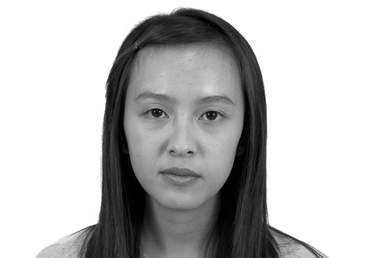

# A tibble: 1 x 7
  format width height colorspace matte filesize density
  <chr>  <int>  <int> <chr>      <lgl>    <int> <chr>  
1 PNG      367    258 Gray       FALSE        0 72x72  

In [341]:
visualize_face <- function(v) {
    v <- as.integer(v) %>% as.raw
    dim(v) <- c(1, 258, 367)
    image_read(v) %>% image_rotate(90)
}
visualize_face(faces_df$face_data[[20]])

Now we can do interesting things with faces. For example, we can average them:

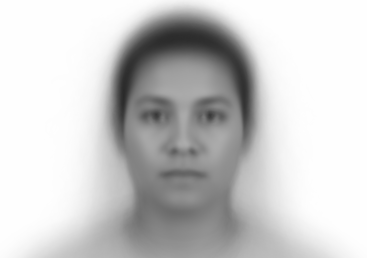

# A tibble: 1 x 7
  format width height colorspace matte filesize density
  <chr>  <int>  <int> <chr>      <lgl>    <int> <chr>  
1 PNG      367    258 Gray       FALSE        0 72x72  

In [342]:
M <- do.call(rbind, faces_df$face_data)
visualize_face(colMeans(M))

Or cluster them:

In [262]:
clust <- kmeans(M, 5)

KMNS(*, k=8): iter=  1, indx=0
 QTRAN(): istep=596, icoun=14, NCP[1:8]= 1178 1147 1147 1175 1163 1178 806 1154
 QTRAN(): istep=1192, icoun=35, NCP[1:8]= 1753 1658 1658 1753 1638 1303 806 1414
 QTRAN(): istep=1788, icoun=55, NCP[1:8]= 1753 1658 1658 2329 2063 1303 806 2329
 QTRAN(): istep=2384, icoun=331, NCP[1:8]= 1753 1658 1658 2463 2649 2649 806 2618
KMNS(*, k=8): iter=  2, indx=15
 QTRAN(): istep=596, icoun=65, NCP[1:8]= 1127 706 0 927 667 1127 156 219
 QTRAN(): istep=1192, icoun=427, NCP[1:8]= 1361 706 0 927 667 1361 156 219
 QTRAN(): istep=1788, icoun=364, NCP[1:8]= 2020 706 0 927 667 2020 1944 219
 QTRAN(): istep=2384, icoun=148, NCP[1:8]= 2020 2832 0 927 667 2832 1944 219
 QTRAN(): istep=2980, icoun=5, NCP[1:8]= 3571 3192 0 927 667 3571 1944 219
 QTRAN(): istep=3576, icoun=121, NCP[1:8]= 4051 4042 4042 927 3700 4051 1944 3695
 QTRAN(): istep=4172, icoun=147, NCP[1:8]= 4581 4621 4042 4621 3700 4581 1944 3695
 QTRAN(): istep=4768, icoun=444, NCP[1:8]= 4920 4621 4042 4621 3700 4920

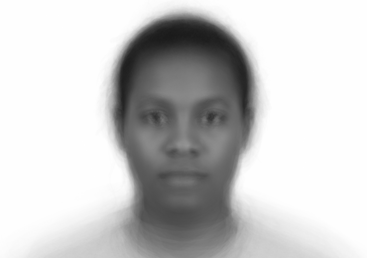

# A tibble: 1 x 7
  format width height colorspace matte filesize density
  <chr>  <int>  <int> <chr>      <lgl>    <int> <chr>  
1 PNG      367    258 Gray       FALSE        0 72x72  

In [358]:
visualize_face(clust$centers[5,])

Now we are going to do something cool. We have already seen that the linear model can be used to write an outcome in terms of a number linear combination of a sum of explanatory variables:

$$y = a_1 x_1 + a_2 x_2 + a_3 x_3 + \cdots$$

Can we do something similar for faces?

``face = a_1 <face_1> + a_2 <face_2> + ...``

What should `face_1`, `face_2` be here?

In [351]:
pca <- prcomp(M, center = T, scale = T)

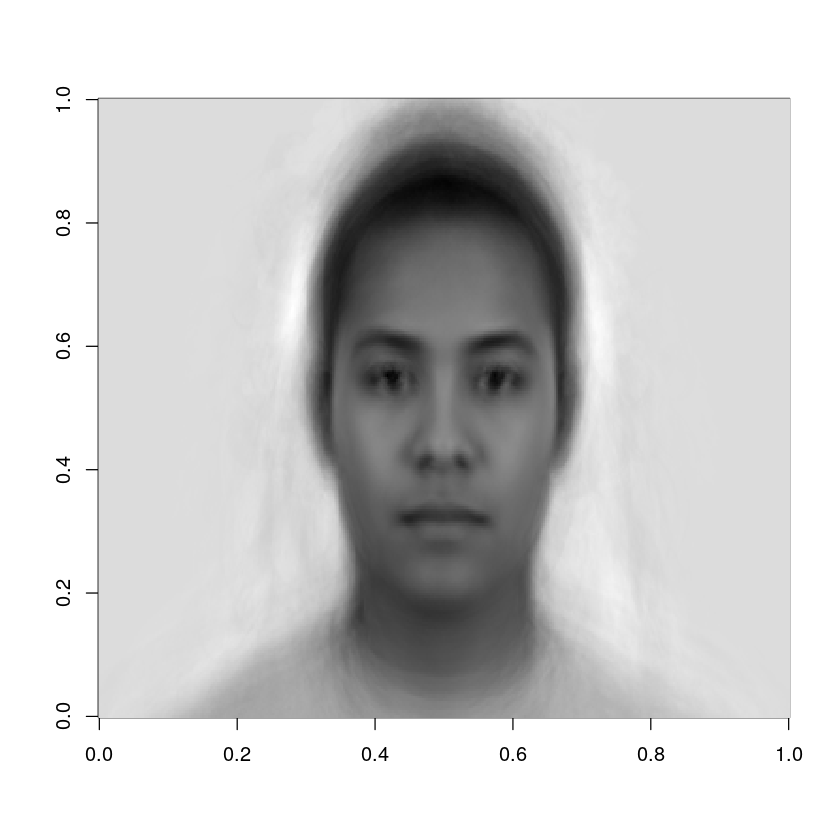

In [421]:
p <- pca$x[100,2:50] %*% t(pca$rotation[,2:50])
p <- scale(p, center = FALSE , scale=1/pca$scale)
p <- scale(p, center = -1 * pca$center, scale=FALSE)
p %>% rev %>%  matrix(nrow=258) %>% t %>% image(col = gray((0:256)/256))

### Example: Image classification
Next will use logistic regression to build an image classifier. We will train a model that recognizes the number 5.

In [422]:
load("mnist.RData")

The `mnist` table is a data frame with 60000 observations and 785 columns. Each row corresponds to a handwritten digit. The first column is the label of that image, and the next $784=28^2$ columns are pixel data for each image. 

In [423]:
mnist %>% slice(1) %>% print

# A tibble: 1 x 785
     X1    X2    X3    X4    X5    X6    X7    X8    X9   X10   X11   X12   X13
  <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl>
1     5     0     0     0     0     0     0     0     0     0     0     0     0
# … with 772 more variables: X14 <dbl>, X15 <dbl>, X16 <dbl>, X17 <dbl>,
#   X18 <dbl>, X19 <dbl>, X20 <dbl>, X21 <dbl>, X22 <dbl>, X23 <dbl>,
#   X24 <dbl>, X25 <dbl>, X26 <dbl>, X27 <dbl>, X28 <dbl>, X29 <dbl>,
#   X30 <dbl>, X31 <dbl>, X32 <dbl>, X33 <dbl>, X34 <dbl>, X35 <dbl>,
#   X36 <dbl>, X37 <dbl>, X38 <dbl>, X39 <dbl>, X40 <dbl>, X41 <dbl>,
#   X42 <dbl>, X43 <dbl>, X44 <dbl>, X45 <dbl>, X46 <dbl>, X47 <dbl>,
#   X48 <dbl>, X49 <dbl>, X50 <dbl>, X51 <dbl>, X52 <dbl>, X53 <dbl>,
#   X54 <dbl>, X55 <dbl>, X56 <dbl>, X57 <dbl>, X58 <dbl>, X59 <dbl>,
#   X60 <dbl>, X61 <dbl>, X62 <dbl>, X63 <dbl>, X64 <dbl>, X65 <dbl>,
#   X66 <dbl>, X67 <dbl>, X68 <dbl>, X69 <dbl>, X70 <dbl>, X71 <dbl>,
#   X72 <dbl>, X73 <dbl>, X74 <dbl>, 

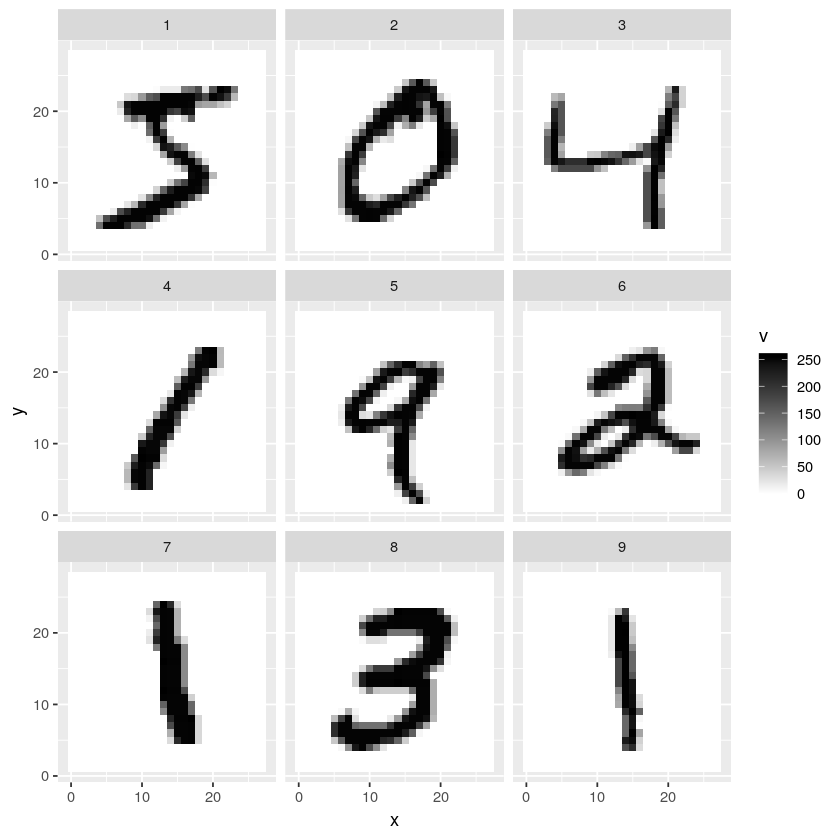

In [425]:
mnist %>% slice(1:9) %>% mutate(i=row_number()) %>% 
    gather("k", "v", X2:X785) %>% mutate(px = as.numeric(str_sub(k, 2)) - 2,
                                         x = px %% 28,
                                         y = 28 - (px %/% 28)) %>% 
    ggplot() + geom_tile(aes(x=x, y=y, fill=v)) + facet_wrap(~ i) + 
    scale_fill_gradient(low="white", high="black")

### Challenge problem
Use logistic regression to build an image classifier that tells whether or not the image is a "5".

In [426]:
train <- slice(mnist, 1:50000)
test <- slice(mnist, -(1:50000))

The `mnist` table is a data frame with 60000 observations and 785 columns. Each row corresponds to a handwritten digit. The first column is the label of that image, and the next $784=28^2$ columns are pixel data for each image. 

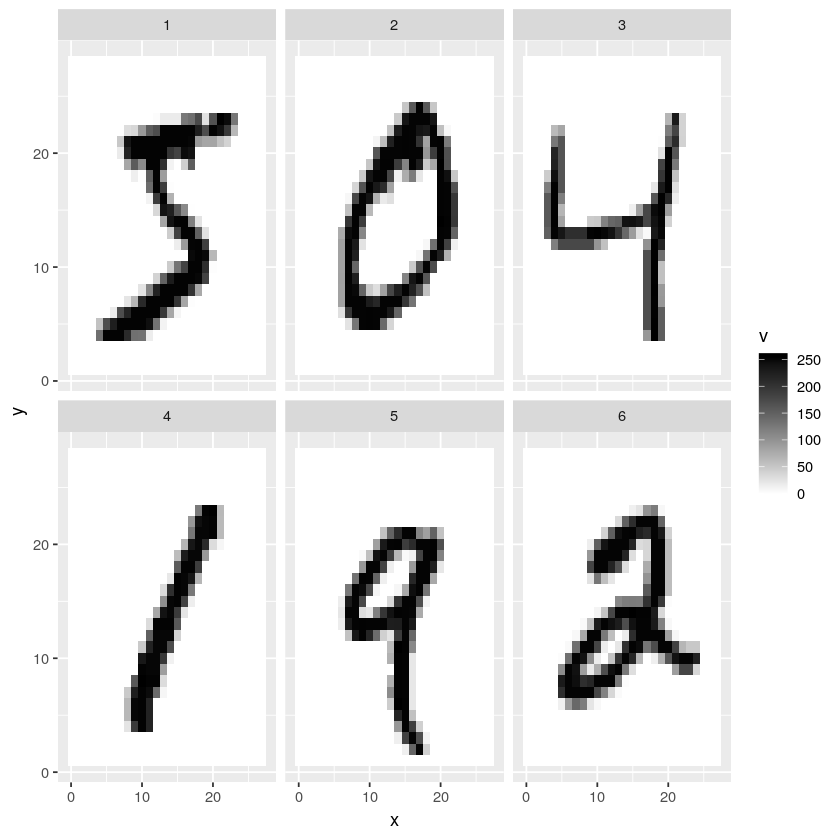

In [429]:
plot_images <- function(df) {
    df %>% mutate(i=row_number()) %>% 
    gather("k", "v", X2:X785) %>% mutate(px = as.numeric(str_sub(k, 2)) - 2,
                                         x = px %% 28,
                                         y = 28 - (px %/% 28)) %>% 
    ggplot() + geom_tile(aes(x=x, y=y, fill=v)) + facet_wrap(~ i) + 
    scale_fill_gradient(low="white", high="black")
}
mnist %>% slice(1:6) %>% plot_images

### Challenge problem
Use logistic regression to build an image classifier that tells whether or not the image is a "5".

In [ ]:
train <- slice(mnist, 1:50000)
test <- slice(mnist, -(1:50000))

If we look back at the pictures, we see that a lot of the data columns a extraneous. For example:

In [ ]:
summary(select(train, X2:X10))

This is a good moment to talk about *dimensionality reduction*. Nowadays we often find ourselves in a situation where there is too much data to do analysis. It can be useful to try and reduce the size of the data. PCA again to the rescue!

In [427]:
pca <- prcomp(train[, 2:785], center=F, scale=F)

The idea of PCA is to find a more efficient way of representing our data. In particular, PCA will find new images that can be used to efficiently represent the original images. To better understand what this means,
let's look at some of those images:

In [ ]:
t(pca$rotation[,1:9]) %>% as_tibble %>% plot_images

These are the first nine principal components. We can write each of our (handwritten digits) as linear combination of these pictures -- literally adding them up.

In [ ]:
plot_images(train[1:9,])

By varying the number of principal components that we use to represent each image, we obtain progressively better results using less data:

In [ ]:
K <- 20  # Number of principal components
P <- pca$rotation[, 1:K]
projected = as_tibble(scale(train[, -1], pca$center, pca$scale) %*% P %*% t(P))
names(projected) <- names(train)[-1]
plot_images(projected[1:9, ])

Now let us see how dimensionality reduction has helped out when trying to fit the logistic regression. Instead of using the complete data set, we will only use the top $k$ principal components:

In [ ]:
y <- train$X1 == 5
K <- 25 # Number of principal components
P <- pca$rotation[, 1:K]
X = scale(train[, -1], pca$center, pca$scale) %*% P
df <- as_tibble(X)
colnames(df) <- colnames(X)
df$y <- y
mdl <- glm(y ~ ., df, family="binomial")

In [ ]:
df %>% add_predictions(mdl) %>% mutate(p = plogis(pred)) %>%
    ggplot + geom_point(aes(x=PC1, y=p, colour=y))

## Test error
To test how well our model does, we will calculate its test error. Our measure of the error will be the (negative) log-likelihood of observing each observation under our model, defined as:

$$\text{loss} = -\sum_i y_i \log(\hat{p}_i) + (1 - y_i) \log(1-\hat{p}_i)$$

In [ ]:
Xtest <- scale(test[, -1], pca$center, pca$scale) %*% P
df <- as_tibble(Xtest)
colnames(df) <- colnames(Xtest)
df$y <- test$X1 == 5
test_err <- df %>% add_predictions(mdl) %>% mutate(p = plogis(pred), 
                                                   error = -(y * log(p) + (1 - y) * log1p(-p)))
sum(test_err$error)

### Challenge problem
Minimize the test error!